> Like SVMs, Decision Trees are versatile Machine Learning algorithms that can per form both classification and regression tasks, and even multioutput tasks

>Decision Trees are also the fundamental components of Random Forests

# Training and Visualizing a Decision Tree

To understand Decision Trees, let’s just build one and take a look at how it makes predictions. The following code trains a DecisionTreeClassifier on the iris dataset

In [51]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

You can visualize the trained Decision Tree by first using the export_graphviz() method to output a graph definition file called iris_tree.dot

In [52]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file='iris_tree.dot',
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
  )

Then you can convert this .dot file to a variety of formats such as PDF or PNG using the command-line tool from the dot graphviz package.1 This command line converts 1 the .dot file to a .png image file

In [57]:
! dot -Tpng iris_tree.dot -o iris_tree.png

Your first decision tree looks like Figure 6-1

<p align='center'>
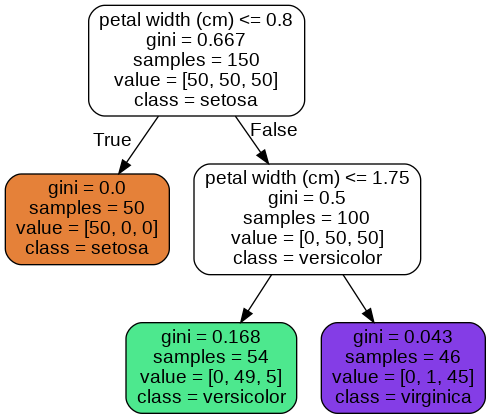
</p>
Figure 6-1. Iris Decision Tree

One of the many qualities of Decision Trees is that they require very little data preparation. In particular, they don’t require feature scaling or centering at all

# Making Predictions

Let’s see how the tree represented in Figure 6-1 makes predictions. Suppose you find an iris flower and you want to classify it

You start at the root node (depth 0, at the top): this node asks whether the flower’s petal length is smaller than 2.45 cm. If it is, then you move down to the root’s left child node (depth 1, left). In this case, it is a leaf node (i.e., it does not have any children nodes), so it does not ask any questions: you can simply look at the predicted class for that node and the Decision Tree predicts that your flower is an Iris-Setosa (class=setosa)

Now suppose you find another flower, but this time the petal length is greater than 2.45 cm. You must move down to the root’s right child node (depth 1, right), which is not a leaf node, so it asks another question: is the petal width smaller than 1.75 cm? If it is, then your flower is most likely an Iris-Versicolor (depth 2, left). If not, it is likely an Iris-Virginica (depth 2, right). It’s really that simple

A node’s samples attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), among which 54 have a petal width smaller than 1.75 cm (depth 2, left)

A node’s value attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 Iris-Setosa, 1 Iris- Versicolor, and 45 Iris-Virginica

Finally, a node’s gini attribute measures its impurity: a node is “pure” (gini=0) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to Iris-Setosa training instances, it is pure and its score is 0 gini





Equation 6-1 shows how the training algo rithm computes the gini score $G_i$ of the $i^{th}$ node. For example, the depth-2 left node has a gini score equal to $1 - (\frac 0{54})^2 - (\frac {49}{54})^2 - (\frac {5}{54})^2 \approx 0.168 $

Equation 6-1. Gini impurity

$$G_i = 1 - \sum^n_{k=1} P_{i, k}^2 $$

* $P_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node

Scikit-Learn uses the CART algorithm, which produces only binary trees: nonleaf nodes always have two children (i.e., questions only have yes/no answers). However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children

Figure 6-2 shows this Decision Tree’s decision boundaries. The thick vertical line rep resents the decision boundary of the root node (depth 0): petal length = 2.45 cm

Since the left area is pure (only Iris-Setosa), it cannot be split any further. However, the right area is impure, so the depth-1 right node splits it at petal width = 1.75 cm (represented by the dashed line)

Since was set to 2, the Decision Tree max_depth stops right there. However, if you set to 3, then the two depth-2 nodes max_depth would each add another decision boundary (represented by the dotted lines)


<p align='center'>
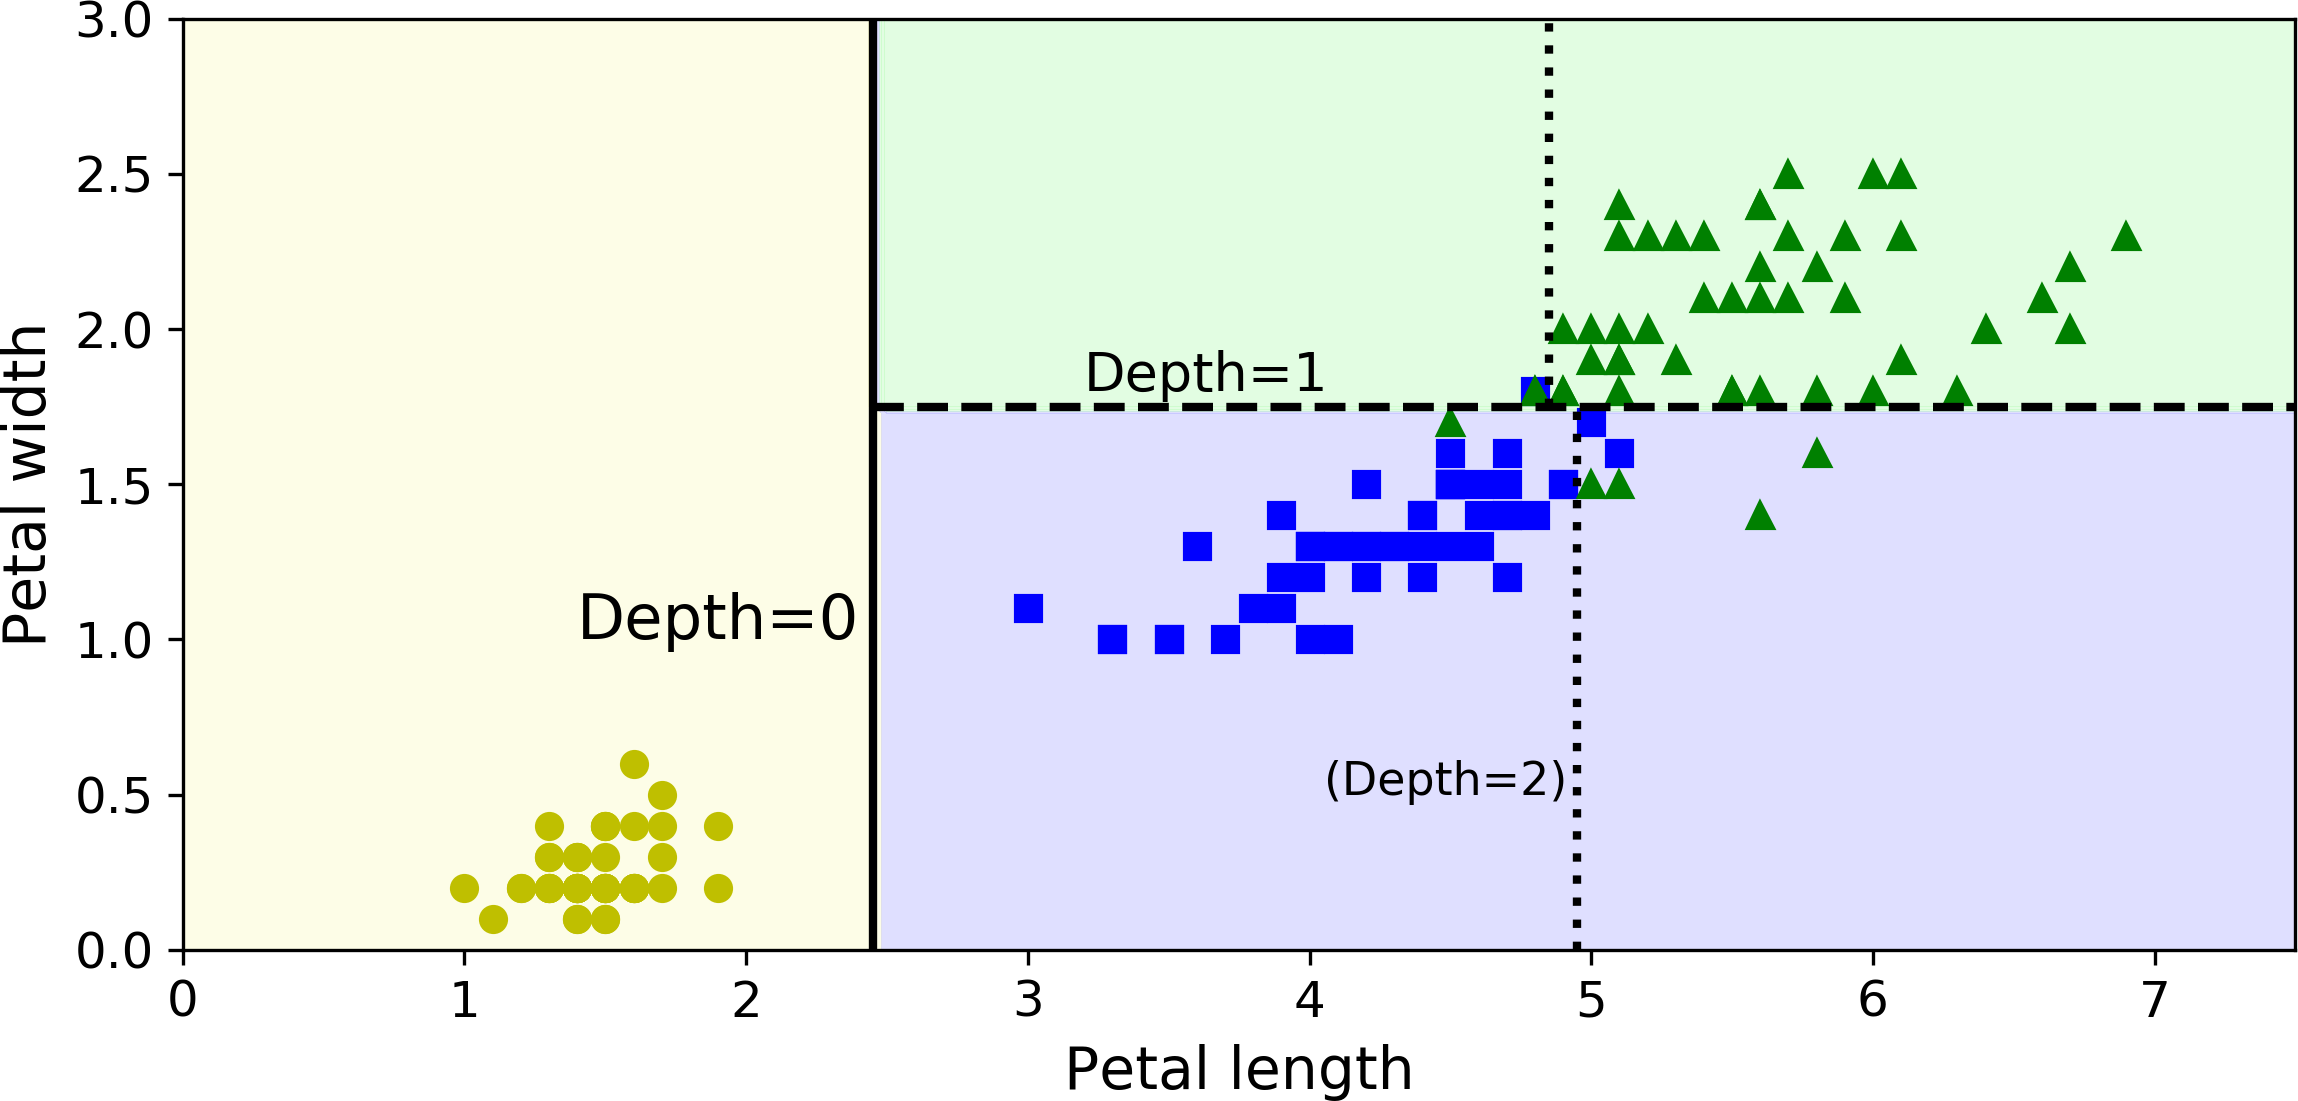
</p>
Figure 6-2. Decision Tree decision boundaries

## Model Interpretation: White Box Versus Black Box



As you can see Decision Trees are fairly intuitive and their decisions are easy to interpret. Such models are often called white box models

In contrast, as we will see, Random Forests or neural networks are generally considered black box models. They make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made

For example, if a neural network says that a particular person appears on a picture, it is hard to know what actually contributed to this prediction: did the model recognize that person’s eyes? Her mouth? Her nose? Her shoes? Or even the couch that she was sitting on? Conversely, Decision Trees provide nice and simple classification rules that can even be applied manually if need be (e.g., for flower classification)

# Estimating Class Probabilities

A Decision Tree can also estimate the probability that an instance belongs to a particular class k: first it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class k in this node

For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corre sponding leaf node is the depth-2 left node, so the Decision Tree should output the following probabilities: 0% for Iris-Setosa (0/54), 90.7% for Iris-Versicolor (49/54), and 9.3% for Iris-Virginica (5/54)

And of course if you ask it to predict the class, it should output Iris-Versicolor (class 1) since it has the highest probability. Let’s check this

In [58]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [59]:
tree_clf.predict([[5, 1.5]])

array([1])

Perfect! Notice that the estimated probabilities would be identical anywhere else in the bottom-right rectangle of Figure 6-2—for example, if the petals were 6 cm long and 1.5 cm wide (even though it seems obvious that it would most likely be an Iris- Virginica in this case)

# The CART Training Algorithm

Scikit-Learn uses the Classification And Regression Tree (CART) algorithm to train Decision Trees (also called “growing” trees)

The idea is really quite simple: the algo rithm first splits the training set in two subsets using a single feature $k$ and a thres hold $t_k$ (e.g., “petal length $\leq$ 2.45 cm”)

How does it choose $k$ and $t_k$? It searches for the
pair ($k, t_k$) that produces the purest subsets (weighted by their size)

The cost function that the algorithm tries to minimize is given by Equation 6-2


Equation 6-2. CART cost function for classification

$$J(k, t_k) = {\frac {m_{left}}{m}} G_{left} + {\frac {m_{right}}{m}} G_{right} \\ \text{where} \begin{cases} G_{left/right} \text{ measures the impurity of the left/right subset, } \\ m_{left/right} \text{ is the number of instances in the left/right subset.} \end{cases}$$

Once it has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets and so on, recursively

It stops recursing once it rea ches the maximum depth (defined by the max_depth hyperparameter), or if it cannot find a split that will reduce impurity

A few other hyperparameters (described in a moment) control additional stopping conditions (min_samples_split, min_samples_leaf, min_weight_fraction_leaf, and max_leaf_nodes)

# Computational Complexity